# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [12]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print('training and testing data loaded')

training and testing data loaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [13]:
### Replace each question mark with the appropriate value.

n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

display training data classes


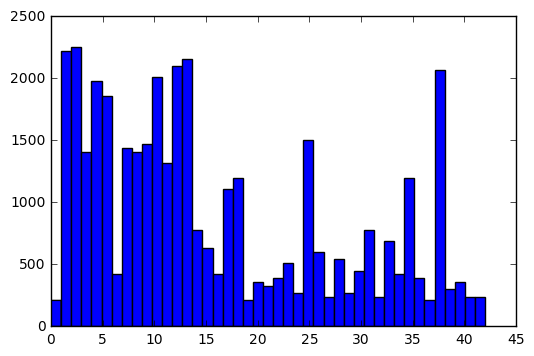

rotated


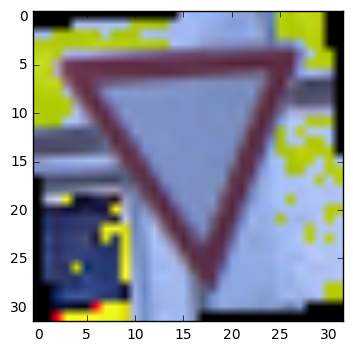

origin image 21468
label: 13


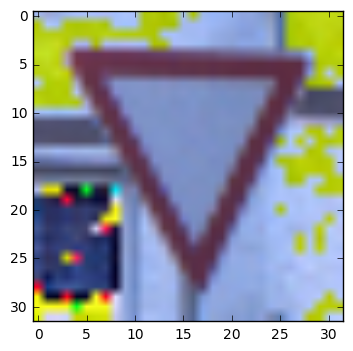

In [35]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

rand_idx = random.randint(0, n_train)
sample_img = X_train[rand_idx]
sample_label = y_train[rand_idx]

def plot_labels(labels):
    bins = len(set(labels))
    plt.hist(y_train, bins=bins)
    plt.show()
    
print('display training data classes')
plot_labels(y_train)


def display_image(img_data):
    plt.imshow(img_data)
    plt.show()
    
# rotate image
print('rotated')
from scipy import ndimage
new_img = ndimage.rotate(sample_img, 5.0, reshape=False)
display_image(new_img)

print('origin image %d' % rand_idx)
print('label: %d' % sample_label)
display_image(sample_img)


In [50]:
# increas training data for classes less than 500 samples
import numpy as np
from os.path import isfile

# TODO(Olala): save data as pickle
training_file_ext = 'train_ext.p'
testing_file_ext = 'test_ext.p'

def extend_data(X, y):
    from collections import Counter
    from scipy import ndimage
    prime = 997
    counter = Counter(y)
    new_X = np.array(X_train)
    new_y = np.array(y_train)
    for i in range(len(y)):
        label = y[i]
        if counter[label] < 250:
            image = X[i]
            angles = [-3.0, -1.0, 1.0, 3.0]
            angle = angles[(i*prime)%len(angles)]
            new_image = ndimage.rotate(image, angle, reshape=False)
            np.append(new_X, [new_image])
            np.append(new_y, [label])
    
    return new_X, new_y
    
X_train_ext = None
y_train_ext = None
if isfile(training_file_ext) and isfile(testing_file_ext):
    # exteded training and testing set found
    with open(training_file, mode='rb') as f:
        X_train_ext = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        y_train_ext = pickle.load(f)
else:
    X_train_ext, y_train_ext = extend_data(X_train, y_train)
    with open(training_file, mode='rb') as f:
        pickle.dump(X_train_ext, f)
    with open(testing_file, mode='rb') as f:
        pickle.dump(y_train_ext, f)


plot_labels(y_train_ext)
        
    

KeyboardInterrupt: 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# normalize image data from ~1.0 to 1.0
X_train = (X_train - 128.)/128.
X_test = (X_test - 128.)/128.


In [16]:
# duplicate classes with too few data


In [17]:
# TODO(Olala): add paddings to image?

In [18]:
import tensorflow as tf

def MyNet(x):
    mu = 0
    sigma = 0.1
    
    # layer 1: convolutional. 32*32*3 -> 28*28*6
    conv1_width = 6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, conv1_width), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(conv1_width))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Down sampling: max pooling. 28*28*6 -> 14*14*6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # layer 2: convolutional. 14*14*6 -> 10*10*16
    conv2_width = 16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_width, conv2_width), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(conv2_width))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Down sampling: 10*10*16 -> 5*5*16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten data: 5*5*16 -> 400
    fc0 = tf.contrib.layers.flatten(conv2)
    conv3_width = 5*5*conv2_width
    
    # Layer 3: fullay connected. 400 -> 120
    fc1_width = 120
    fc1_W = tf.Variable(tf.truncated_normal(shape=(conv3_width, fc1_width), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(fc1_width))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Layer 4: fully connected. 120 -> 84
    fc2_width = 84
    fc2_W = tf.Variable(tf.truncated_normal(shape=(fc1_width, fc2_width), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(fc2_width))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: fully connected. 84 -> 43
    fc3_W = tf.Variable(tf.truncated_normal(shape=(fc2_width, n_classes), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [19]:
# Training pipeline
EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = MyNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

# TODO(Olala): try other optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [20]:
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
# train test split
from sklearn.model_selection import train_test_split
loss = []
train_accuracy = []
validate_accuracy = []

with tf.Session() as sess:
    print('Session start')
    sess.run(tf.global_variables_initializer())
    
    # save 20% data as testing data
    _X_train, _X_validate, _y_train, _y_validate = train_test_split(
        X_train, y_train, test_size=0.2, random_state=10)

    for i in range(EPOCHS):
        num_examples = len(_X_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = _X_train[offset:end], _y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        l = sess.run(loss_operation, feed_dict={x: _X_train, y: _y_train})
        t_acc = evaluate(_X_train, _y_train)
        v_acc = evaluate(_X_validate, _y_validate)
        loss.append(l)
        train_accuracy.append(t_acc)
        validate_accuracy.append(v_acc)
        print('EPOCH {0:}, t_acc: {1:.4f} v_acc: {2:.4f}'.format(i+1, t_acc, v_acc))

    v_acc = evaluate(_X_validate, _y_validate)
    print('Finished with accuracy {0:.3f}'.format(v_acc))
    

Session start
EPOCH 1, t_acc: 0.7493 v_acc: 0.7475
EPOCH 2, t_acc: 0.9159 v_acc: 0.9114
EPOCH 3, t_acc: 0.9472 v_acc: 0.9397
EPOCH 4, t_acc: 0.9619 v_acc: 0.9533
EPOCH 5, t_acc: 0.9686 v_acc: 0.9596
EPOCH 6, t_acc: 0.9685 v_acc: 0.9587
EPOCH 7, t_acc: 0.9750 v_acc: 0.9662
EPOCH 8, t_acc: 0.9874 v_acc: 0.9764
EPOCH 9, t_acc: 0.9924 v_acc: 0.9816
EPOCH 10, t_acc: 0.9841 v_acc: 0.9707
EPOCH 11, t_acc: 0.9935 v_acc: 0.9825
EPOCH 12, t_acc: 0.9894 v_acc: 0.9767
EPOCH 13, t_acc: 0.9913 v_acc: 0.9772
EPOCH 14, t_acc: 0.9920 v_acc: 0.9806
EPOCH 15, t_acc: 0.9920 v_acc: 0.9827
EPOCH 16, t_acc: 0.9922 v_acc: 0.9818
EPOCH 17, t_acc: 0.9895 v_acc: 0.9763
EPOCH 18, t_acc: 0.9948 v_acc: 0.9813
EPOCH 19, t_acc: 0.9909 v_acc: 0.9776
EPOCH 20, t_acc: 0.9970 v_acc: 0.9839
EPOCH 21, t_acc: 0.9949 v_acc: 0.9856
EPOCH 22, t_acc: 0.9942 v_acc: 0.9830
EPOCH 23, t_acc: 0.9937 v_acc: 0.9809
EPOCH 24, t_acc: 0.9982 v_acc: 0.9875
EPOCH 25, t_acc: 0.9940 v_acc: 0.9795
EPOCH 26, t_acc: 0.9970 v_acc: 0.9842
EPOCH 2

start plotting ...


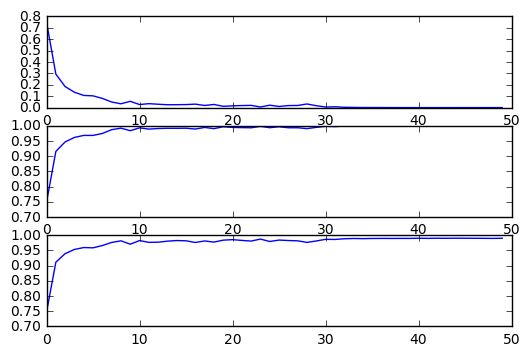

In [22]:
print('start plotting ...')

plt.subplot(311)
plt.plot(loss)
plt.subplot(312)
plt.plot(train_accuracy)
plt.subplot(313)
plt.plot(validate_accuracy)


In [ ]:
# got 0.985 for the first attemp

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
2. make lables one-hot encoded
3. normalized image data into range -1.0 ~ 1.0

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

1. LeNet5
    * First attemp (LeNet5): As a starting point, I tried LeNet5 with a little modification. I used sklearn train_test_split with 10% as my validate set and run it for 10 EPOCHS (a little bit like k-fold k=10). 
    * The result on the testing set was quite good(0.992) but not as well on the testing set (0.913), so I think it should be overfitting.
2. Drop-out
    *
    *

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.